In [1]:
# imports 
import numpy as np
import monai
from monai.transforms import (
    Compose,
    LoadImaged,
    LoadImage,
    Spacing,
    CenterSpatialCrop,
    ScaleIntensityd,
    AsChannelLast,
    Resized,
    AsChannelLastd,
    SqueezeDimd,
    EnsureChannelFirstd,
    ResizeWithPadOrCropd,

)


from monai.data import Dataset, DataLoader
import itertools
import os

from sklearn.model_selection import KFold

from monai.networks.nets import UNet

import math
import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk

2024-01-29 11:10:24.884878: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 11:10:24.963912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 11:10:24.963988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 11:10:24.965929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 11:10:24.980572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

# MRI

In [2]:
transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
            ]
        )

In [36]:
data_dir = "../other/MR_withGT"
images = sorted(glob.glob(os.path.join(data_dir, "img2_slice*.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "lab2_slice*.nii.gz")))

example_dataset = [{"image": img, "label": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))

16


In [7]:
data_dir = "../other/CT_withGT_proc/annotated"
images = sorted(glob.glob(os.path.join(data_dir, "images/case_1001/slice*.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "labels/case_1001/slice*.nii.gz")))

example_dataset = [{"image": img, "label": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))

16


In [8]:
example_patch_ds = Dataset(data=example_dataset, transform=transforms)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1)

[0. 1. 2. 3. 4. 5.]


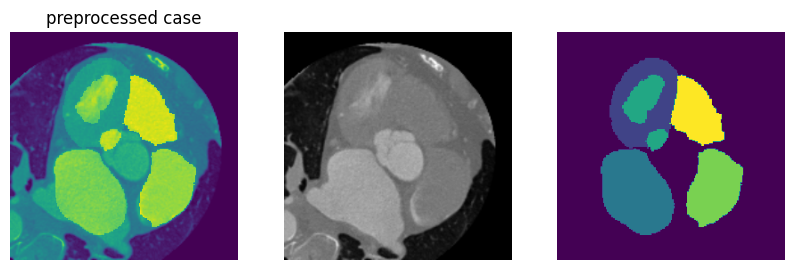

[0. 1. 2. 3. 4. 5.]


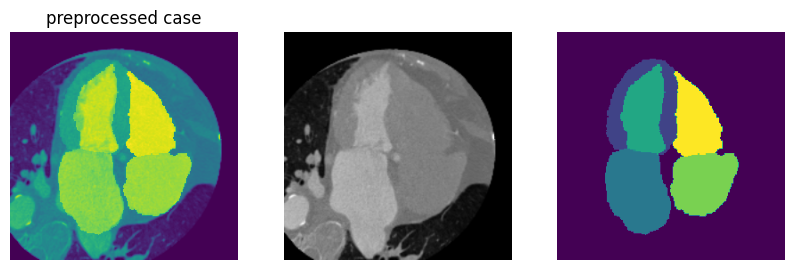

[0. 1. 2. 3. 4. 5.]


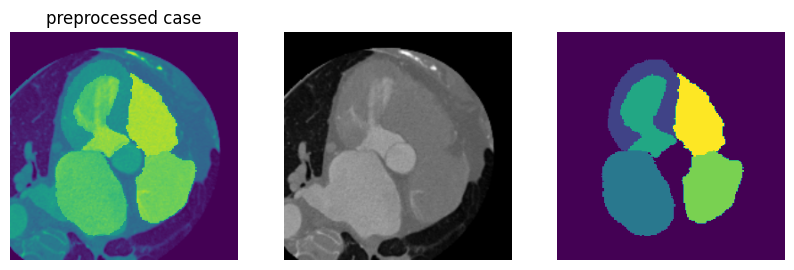

[0. 1. 2. 3. 4. 5.]


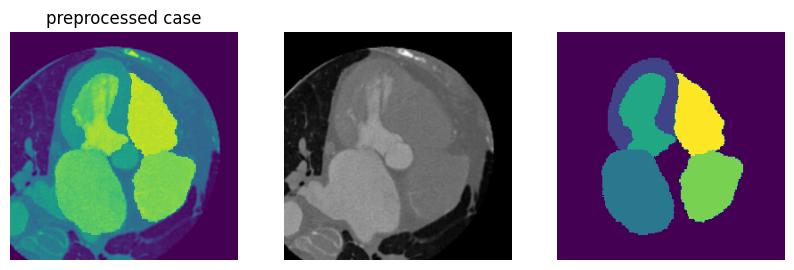

[0. 1. 2. 3. 4. 5.]


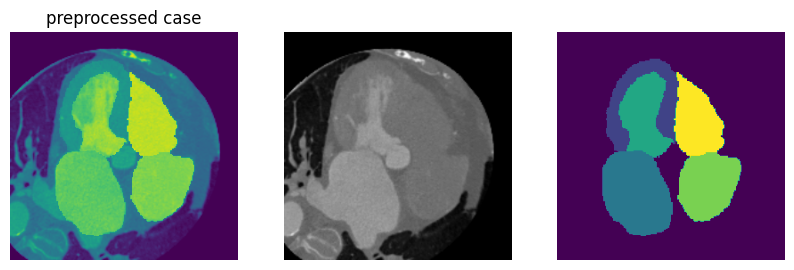

[0. 1. 2. 3. 4. 5.]


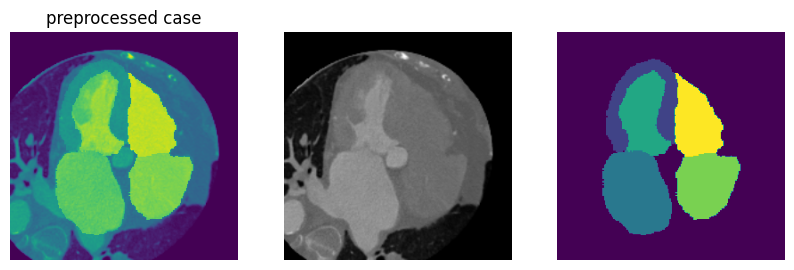

[0. 1. 2. 3. 4. 5.]


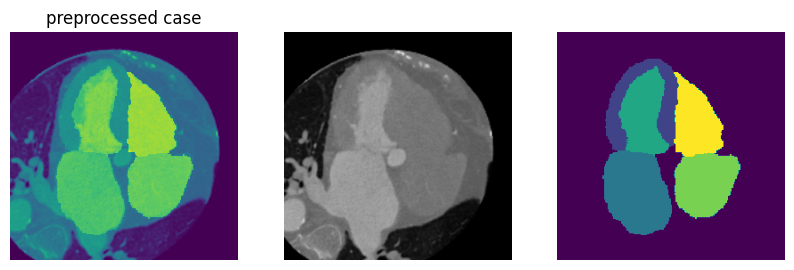

[0. 1. 2. 3. 4. 5.]


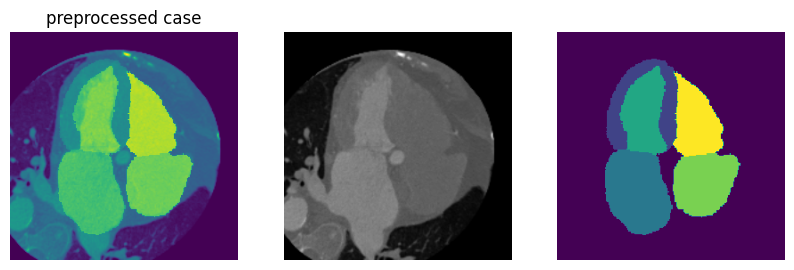

[0. 1. 2. 3. 4. 5.]


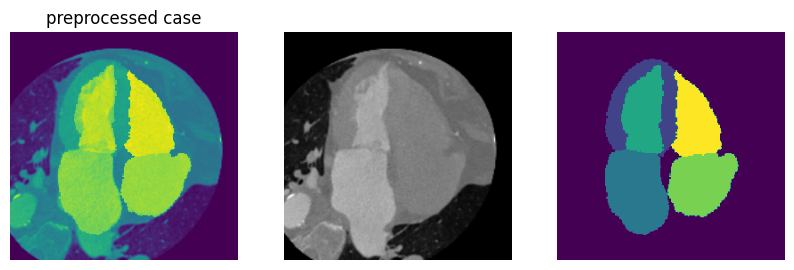

[0. 1. 2. 3. 4. 5.]


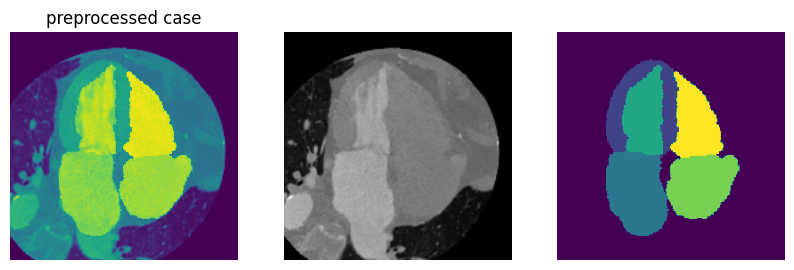

[0. 1. 2. 3. 4. 5.]


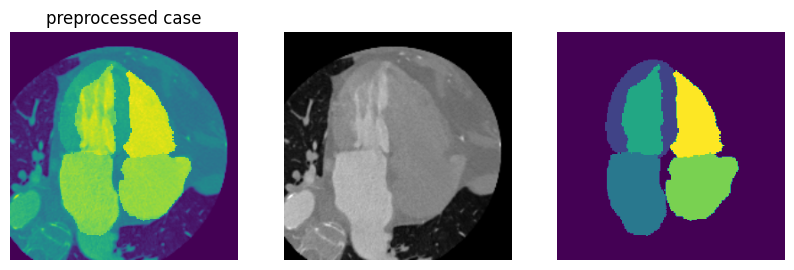

[0. 1. 2. 3. 4. 5.]


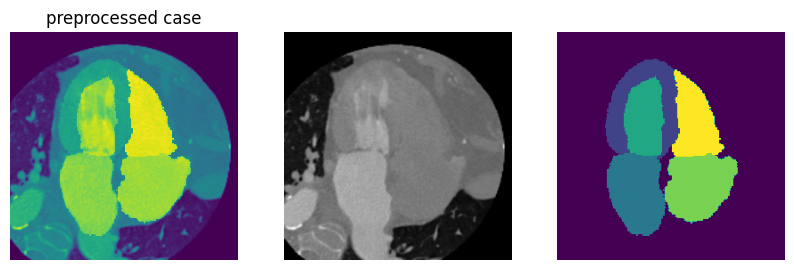

[0. 1. 2. 3. 4. 5.]


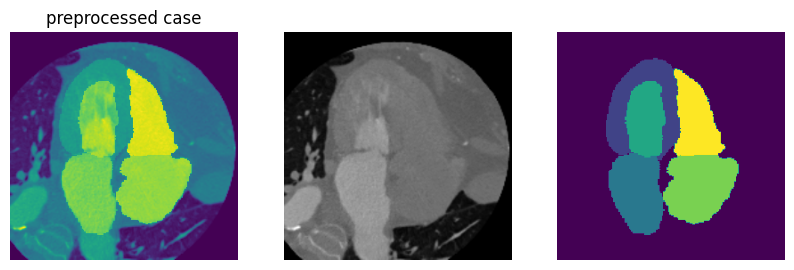

[0. 1. 2. 3. 4. 5.]


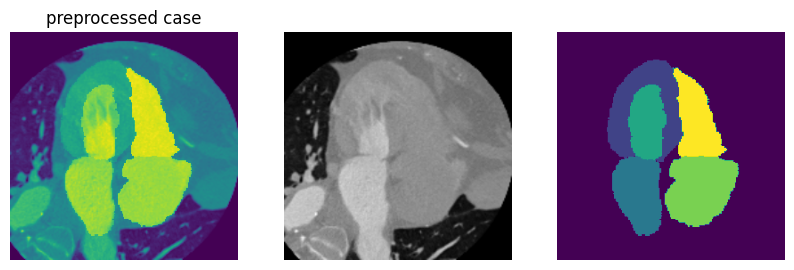

[0. 1. 2. 3. 4. 5.]


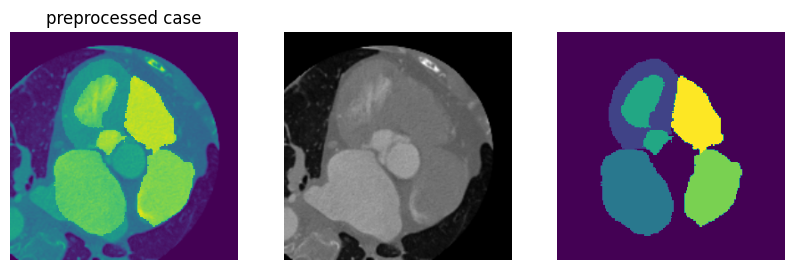

[0. 1. 2. 3. 4. 5.]


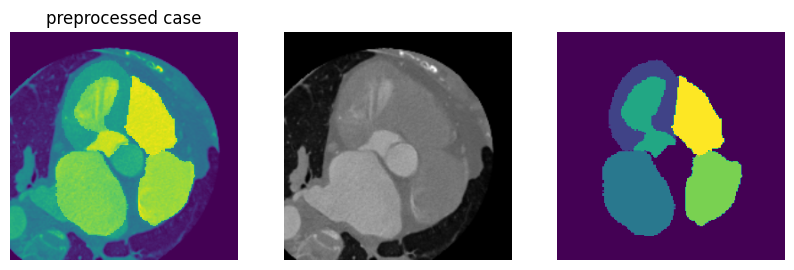

In [9]:
for batch in patch_data_loader:
    image, label = batch["image"][0], batch["label"][0]
    label = np.array(label)
    uni = np.unique(label)
    print(uni)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"preprocessed case")
    plt.axis("off")
    plt.imshow((image.squeeze() + label.squeeze()/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(label.squeeze())
    plt.show()

In [7]:
file_original = f"../other/CT_withGT/img36_slice2.nii.gz"
example_im_original = LoadImage()(file_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../other/CT_withGT/lab36_slice2.nii.gz"
example_label_original = LoadImage()(label_original)
print(f"label data shape: {example_label_original.shape}")

image data shape: torch.Size([1, 240, 220])
label data shape: torch.Size([1, 240, 220])


In [8]:
file_original = f"../other/CT_withGT/img33_slice1.nii.gz"
example_im_original = transforms(file_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../other/CT_withGT/lab33_slice1.nii.gz"
example_label_original = transforms(label_original)
print(f"label data shape: {example_label_original.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title(f"preprocessed case")
plt.axis("off")
plt.imshow((example_im_original + example_label_original) / 2)
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(example_label_original)
plt.show()

RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x147d28e1cfd0>

In [ ]:
print(example_im_original[80:120,80:120,0])

metatensor([[0.4534, 0.4524, 0.4502,  ..., 0.4571, 0.4499, 0.4380],
        [0.4487, 0.4552, 0.4567,  ..., 0.4421, 0.4325, 0.4285],
        [0.4349, 0.4504, 0.4580,  ..., 0.4364, 0.4327, 0.4226],
        ...,
        [0.3782, 0.3834, 0.3955,  ..., 0.5978, 0.6002, 0.5966],
        [0.3681, 0.3797, 0.3879,  ..., 0.5979, 0.6006, 0.5916],
        [0.3747, 0.3791, 0.3817,  ..., 0.5863, 0.5840, 0.5768]])
